In [31]:
import tensorflow as tf
# import tensorflow_hub as hub

import math as math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import Callback

import keras.backend as K

import pandas as pd
import numpy as np
import cv2 # подгрузка и работа с данными
import os
import tqdm # счетчик и красивый прогресс бар

IMAGE_PATH = '/storage/Study/DBO/dl/rosneft_challenge/rosneft_challenge/make_rofneft_predict/data/train/images/'
MASK_PATH = '/storage/Study/DBO/dl/rosneft_challenge/rosneft_challenge/make_rofneft_predict/data/train/train.csv'
TEST_PATH = '/storage/Study/DBO/dl/rosneft_challenge/rosneft_challenge/make_rofneft_predict/data/test/images/'
SAMPLE_PATH = '/storage/Study/DBO/dl/rosneft_challenge/rosneft_challenge/make_rofneft_predict/data/sample_submission.csv'

def rle2mask(mask_rle, shape):
    # эта функция взята с конкурса и я её оставил как есть
    """
    mask_rle: run-length as string formated (start length)ы
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if mask_rle != mask_rle:
        return np.zeros_like(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

class TrainDataset():
    # немного переписанный загрузчик данных опять же с конкурса
    def __init__(self, image_dir, train):
        self.image_dir = image_dir
        self.train = train
        self.image_uses = []

    def __getitem__(self, index):
        
        
        img_name = self.train.iloc[index]['ImageId']
        if img_name in self.image_uses:
            return 'hups'
        else:
            self.image_uses.append(img_name)
            path = os.path.join(self.image_dir, img_name)
            img = cv2.imread(path)
            img = cv2.resize(img,(384,384))

            ce_mask = [
                (i + 1) * rle2mask(rle, shape=(img.shape[0], img.shape[1])) \
                    for i, rle in enumerate(self.train[self.train['ImageId']==img_name]['EncodedPixels'])
            ]
            ce_mask = np.sum(ce_mask, axis=0, dtype=np.float32)


            result = {
                'image':img, 
                'mask': ce_mask,
                'pick_name':img_name
            }
            return result
    
    def __len__(self, ):
        return len(self.train)
    
train = pd.read_csv(MASK_PATH)
train_dataset = TrainDataset(
    image_dir=IMAGE_PATH, 
    train=train)


In [2]:
x_images1 = None
y_images1 = None

for n, i in enumerate(train_dataset):
    if type(i)==str:
        pass
    else:
        if x_images1 is None:
            x_images1 = np.empty((384,384,3,1))
            y_images1 = np.empty((384,384,3,1))
            x_images1 = np.expand_dims(np.delete(i['image'], np.s_[1:], axis=2).squeeze(), axis=2)[:,:,:,None]
            y_images1 = np.expand_dims(i['mask'], axis=2)[:,:,:,None]
        else:
            x_images1 = np.concatenate((x_images1, np.expand_dims(np.delete(i['image'], np.s_[1:], axis=2).squeeze(), axis=2)[:,:,:,None]), axis=3)
            y_images1 = np.concatenate((y_images1, np.expand_dims(i['mask'], axis=2)[:,:,:,None]), axis=3)

x_images1 = np.moveaxis(x_images1, 3, 0)
y_images1 = np.moveaxis(y_images1, 3, 0)

Кстати, посмотрев на данные, какие особенности данных мы видим?

In [4]:
x_images1.shape

(896, 384, 384, 1)

In [5]:
y_images1.shape

(896, 384, 384, 1)

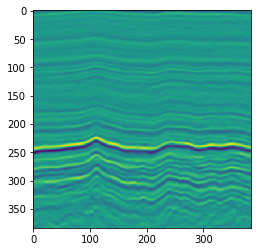

In [6]:
plt.imshow(x_images1[894].squeeze())

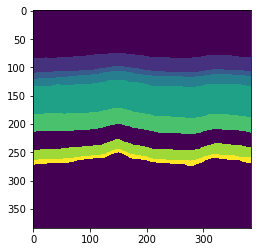

In [7]:
plt.imshow(y_images1[894].squeeze())

Такс, что мы хотим делать с данными дальше ? Можем ли мы что-то предположить заранее?

In [7]:
#### Ваш код игры с данными

В самой задачке на бустере используется метрика dice по границе и всей области.
Мы упростим задачу, просто берем dice по области.

Собственно нам надо реализовать следующую формулу

\begin{equation}
dice = \sum_{k=0}^7(\cfrac{2*|prediction \cap truch|}{|prediction| + |truch|})
\end{equation}

Ну и чтобы в случае чего не делить на ноль, надо добавить небольшой эпсилон к верхней и нижней части.

In [8]:
def dice_coef(y_true, y_pred):
    class_list = [1,2,3,4,5,6,7]
    sum_ = []
    for i in class_list:
        y_true_f = tf.dtypes.cast(K.flatten(y_true[:,:,:,i-1]), tf.double)
        y_pred_f = tf.dtypes.cast(K.flatten(y_pred[:,:,:,i-1]), tf.double)
        intersection = K.sum(y_true_f * y_pred_f)
        sum_.append((2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f)))
    return sum(sum_)

def dice_loss():
    def dice(y_true, y_pred):
        return -dice_coef(y_true, y_pred)
    return dice

In [9]:
def batch_generator(X, y, batch_size=1):
    while True:
        np.random.seed(42)
        perm = np.random.permutation(len(X))
        X = X[perm]
        y = y[perm]
        for i in range(0, X.shape[0], batch_size):
            rem = X.shape[0] % batch_size
            X_batch, y_batch = X[i:i+batch_size], y[i:i+batch_size]
            if X.shape[0]-i < batch_size:
                X_batch, y_batch = X[i:i+rem], y[i:i+rem]   

            class_list = [1,2,3,4,5,6,7]

            y_images2 = np.zeros((batch_size, 384, 384, 7))

            for i, y_trr in enumerate(y_batch):
                for obj_class in class_list:
                    y_images2[i,:,:,int(obj_class-1)] = ((y_trr == obj_class).astype(int)).astype(float).squeeze()
                pass

            yield X_batch, y_images2

Ну что же, теперь пришло время к моделям!
Начнем с простой модельки - fully-convolution-net.

И да - архитектура на ваш вкус и цвет :)

Но прежде чем начинать, какие callback нам точно потребуются? (вне зависимости от архитектуры)

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, concatenate

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [12]:
TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS = (384,384,1)

# Вход в сетку 
inputs = Input((TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS))

# 128
down1 = Conv2D(49, (3, 3), activation="relu", padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Conv2D(49, (3, 3), activation="relu", padding='same')(down1)
down1 = BatchNormalization()(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

# 8
center = Conv2D(98, (3, 3), activation="relu", padding='same')(down1_pool)
center = BatchNormalization()(center)
center = Conv2D(98, (3, 3), activation="relu", padding='same')(center)
center = BatchNormalization()(center)

# 64
up1 = UpSampling2D((2, 2))(center)
up1 = Conv2D(49, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Conv2D(49, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Conv2D(49, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)

# 128
outputs = Conv2D(7, (1, 1), activation='sigmoid')(up1)
model_fully = Model(inputs=inputs, outputs=outputs)

In [14]:
model_fully.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 384, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 384, 384, 49)      490       
_________________________________________________________________
batch_normalization (BatchNo (None, 384, 384, 49)      196       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 384, 384, 49)      21658     
_________________________________________________________________
batch_normalization_1 (Batch (None, 384, 384, 49)      196       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 192, 192, 49)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 192, 192, 98)      43316 

In [13]:
optimizer = tf.optimizers.Adam(lr=0.02)
model_fully.compile(
    optimizer=optimizer, 
    loss=dice_loss(),
    metrics=[dice_coef]
)

In [25]:
def lr_scheduler(epoch):
    drop = 0.5
    epochs_drop = 1
    lrate = INIT_LR * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(lr_scheduler)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x_images1, y_images1, random_state=42)

In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(672, 384, 384, 1) (224, 384, 384, 1) (672, 384, 384, 1) (224, 384, 384, 1)


In [18]:
history = model_fully.fit_generator(batch_generator(X_train, y_train, 4),
                    epochs=5,
                    steps_per_epoch=168,
                    validation_data=batch_generator(X_test, y_test, 4),
                    validation_steps=56
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 112 steps
Epoch 1/5
112/112 [==============================] - 540s 5s/step - loss: -3.0431 - dice_coef: 3.0431


KeyboardInterrupt: 

In [ ]:
preds = model_fully.predict(x_images1[0:1])

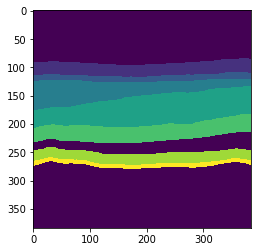

In [63]:
plt.imshow(y_images1[1].squeeze())

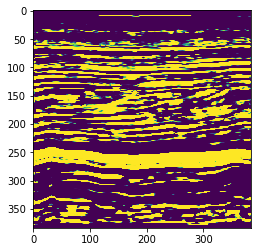

In [37]:
plt.imshow(np.max(model_fully.predict(x_images1[1:2]).squeeze(),axis = 2))

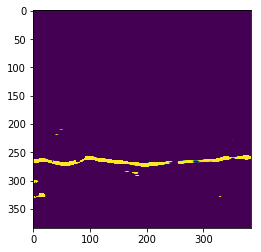

In [48]:
plt.imshow(preds.squeeze()[:,:,6])

Собираем u-net. Смотрим как оно :)

In [19]:
TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS = (384,384,1)

# Вход в сетку 
inputs = Input((TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS))

# 128
down1 = Conv2D(64, (3, 3), activation="relu", padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Conv2D(64, (3, 3), activation="relu", padding='same')(down1)
down1 = BatchNormalization()(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

# 64
down2 = Conv2D(128, (3, 3), activation="relu", padding='same')(down1_pool)
down2 = BatchNormalization()(down2)
down2 = Conv2D(128, (3, 3), activation="relu", padding='same')(down2)
down2 = BatchNormalization()(down2)
down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)

# 32
down3 = Conv2D(256, (3, 3), activation="relu", padding='same')(down2_pool)
down3 = BatchNormalization()(down3)
down3 = Conv2D(256, (3, 3), activation="relu", padding='same')(down3)
down3 = BatchNormalization()(down3)
down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)

# 16
down4 = Conv2D(512, (3, 3), activation="relu", padding='same')(down3_pool)
down4 = BatchNormalization()(down4)
down4 = Conv2D(512, (3, 3), activation="relu", padding='same')(down4)
down4 = BatchNormalization()(down4)
down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)

# 8
center = Conv2D(1024, (3, 3), activation="relu", padding='same')(down4_pool)
center = BatchNormalization()(center)
center = Conv2D(1024, (3, 3), activation="relu", padding='same')(center)
center = BatchNormalization()(center)

# center

up4 = UpSampling2D((2, 2))(center)
up4 = concatenate([down4, up4], axis=3)  # ПРОКИНУЛИ СВЯЗЬ МЕЖДУ СТАРЫМ И НОВЫМ!!! 

up4 = Conv2D(512, (3, 3), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Conv2D(512, (3, 3), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Conv2D(512, (3, 3), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)

# 16
up3 = UpSampling2D((2, 2))(up4)
up3 = concatenate([down3, up3], axis=3) # ПРОКИНУЛИ СВЯЗЬ МЕЖДУ СТАРЫМ И НОВЫМ!!! 

up3 = Conv2D(256, (3, 3), activation="relu", padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Conv2D(256, (3, 3), activation="relu",  padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Conv2D(256, (3, 3), activation="relu", padding='same')(up3)
up3 = BatchNormalization()(up3)

# 32
up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([down2, up2], axis=3) # ПРОКИНУЛИ СВЯЗЬ МЕЖДУ СТАРЫМ И НОВЫМ!!! 

up2 = Conv2D(128, (3, 3), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Conv2D(128, (3, 3), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Conv2D(128, (3, 3), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)

# 64
up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([down1, up1], axis=3) # ПРОКИНУЛИ СВЯЗЬ МЕЖДУ СТАРЫМ И НОВЫМ!!! 

up1 = Conv2D(64, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Conv2D(64, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Conv2D(64, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)

# 128
outputs = Conv2D(7, (1, 1), activation='sigmoid')(up1)
model_unet = Model(inputs=inputs, outputs=outputs)

In [59]:
optimizer = tf.optimizers.Adam(lr=0.02)
model_unet.compile(
    optimizer=optimizer, 
    loss=dice_loss(),
    metrics=[dice_coef]
)

In [60]:
def lr_scheduler(epoch):
    drop = 0.5
    epochs_drop = 1
    lrate = 0.02 * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(lr_scheduler)

In [61]:
history = model_unet.fit_generator(batch_generator(X_train, y_train, 2),
                    epochs=10,
                    steps_per_epoch=326,
                    validation_data=batch_generator(X_test, y_test, 2),
                    validation_steps=112,
                    callbacks=[lrate]
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 326 steps, validate for 112 steps
Epoch 1/10
326/326 [==============================] - 343s 1s/step - loss: -6.3404 - dice_coef: 6.3404 - val_loss: -4.9629 - val_dice_coef: 4.9629
Epoch 2/10
326/326 [==============================] - 342s 1s/step - loss: -6.5585 - dice_coef: 6.5585 - val_loss: -6.4218 - val_dice_coef: 6.4218
Epoch 3/10
326/326 [==============================] - 342s 1s/step - loss: -6.7110 - dice_coef: 6.7110 - val_loss: -6.7302 - val_dice_coef: 6.7302
Epoch 4/10
326/326 [==============================] - 342s 1s/step - loss: -6.7911 - dice_coef: 6.7911 - val_loss: -6.8075 - val_dice_coef: 6.8075
Epoch 5/10
326/326 [==============================] - 342s 1s/step - loss: -6.8266 - dice_coef: 6.8266 - val_loss: -6.8155 - val_dice_coef: 6.8155
Epoch 6/10
326/326 [==============================] - 343s 1s/step - loss: -6.8475 - dice_coef: 6.8475 - val_loss: -6.8413 - val_dice_coef: 6.8413
Epoch 7/10
326/326 [====

In [62]:
model_unet.save('model_unet.h5')

In [63]:
preds = model_unet.predict(X_test[0:1])

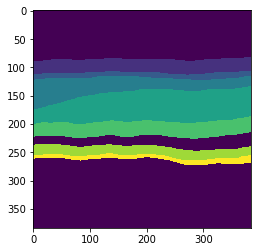

In [65]:
plt.imshow(y_test[1].squeeze())

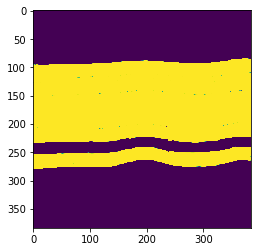

In [72]:
plt.imshow(np.max(model_unet.predict(X_test[0:1]).squeeze(),axis = 2))

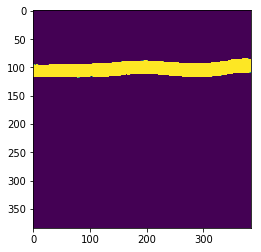

In [68]:
plt.imshow(preds.squeeze()[:,:,0])

Ну чтож, время вашего творчества - меняем архитектуры, смотрим и вспоминаем, что же ещё мы не учли и что может нам помочь. Да и вообще -какие подходы ещё не использованы !

In [ ]:
### играемся на все деньги

И доп задачка для всех - а что если обучить часть (или весь) unet как автоэнкодер.....


In [91]:
##############################

In [ ]:
# x_images = []
# y_images = []
# for i in train_dataset:
#     if type(i)==str:
#         pass
#     else:
#         x_images.append(i['image'])
#         y_images.append(i['mask']) 
            

In [ ]:
class_list = [1,2,3,4,5,6,7]

In [ ]:
dict_start = {}
dict_end = {}

for i in class_list:
    dict_start[i] = []
    dict_end[i] = []

for y_trr in y_images:
    for obj_class in class_list:
        for i in range(1,len(first_col)):
            if first_col[i]==obj_class and first_col[i-1] != obj_class:
                dict_start[obj_class].append(i)
            elif first_col[i-1]==obj_class and first_col[i] == obj_class:
                dict_end[obj_class].append(i)
                break
                

In [ ]:
a = np.ones((384,384))
print(list(dict_total.values()))
dict_list = list(dict_total.values())

for i, pix in enumerate(dict_total.values()):
    print(i+1, int(dict_list[i][0]))
    if i == 0:
        start = 0
        end = int(dict_list[i][0])
        tclass = i+1
    else:
        start = int(dict_list[i-1][0])
        end = int(dict_list[i][0])
        tclass = i+1
    
    a[start:end, :] = a[start:end, :]*tclass


In [ ]:
plt.imshow(a)

In [ ]:
dict_total = {}
for obj_class in class_list:
    dict_total[obj_class] = [np.median(dict_start[obj_class]),
                            np.median(dict_end[obj_class])]
dict_total

In [ ]:
class_list = [1,2,3,4,5,6,7]

y_images2 = np.zeros((896, 384, 384, 7))

for i, y_trr in enumerate(y_images1):
    for obj_class in class_list:
        y_images2[i,:,:,int(obj_class-1)] = ((y_trr == obj_class).astype(int)).astype(float).squeeze()
    pass
                

In [ ]:
def batch_generator(X, y, batch_size=1):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    X = X[perm]
    y = y[perm]
    for i in range(0, X.shape[0], batch_size):
        rem = X.shape[0] % batch_size
        X_batch, y_batch = X[i:i+batch_size], y[i:i+batch_size]
        if X.shape[0]-i < batch_size:
            X_batch, y_batch = X[i:i+rem], y[i:i+rem]   
        
        class_list = [1,2,3,4,5,6,7]

        y_images2 = np.zeros((batch_size, 384, 384, 7))
#         x_images2 = np.tile(X_batch,(1,7))
        
        for i, y_trr in enumerate(y_batch):
            for obj_class in class_list:
                y_images2[i,:,:,int(obj_class-1)] = ((y_trr == obj_class).astype(int)).astype(float).squeeze()
            pass

        
#         yield x_images2, y_images2
        yield X_batch, y_images2

In [ ]:
def dice_coef(y_true, y_pred):
#     print(y_true.shape, y_pred.shape)
    
    class_list = [1,2,3,4,5,6,7]
    sum_ = []
    for i in class_list:
        y_true_f = tf.dtypes.cast(K.flatten(y_true[i]), tf.double)
        y_pred_f = tf.dtypes.cast(K.flatten(y_pred[i]), tf.double)
        intersection = K.sum(y_true_f * y_pred_f)
        sum_.append((2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f)))
    return sum(sum_)

def dice_loss():
    def dice(y_true, y_pred):
        return -dice_coef(y_true, y_pred)
    return dice